In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # disable GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from nvae_layers import SqueezeExciteLayer
from nvae_layers import FactorizedDownsample
from nvae_layers import ResidualDecoderCell
from nvae_layers import ResidualEncoderCell
from nvae_layers import MergeCellPeak
from nvae_layers import MergeCell
from nvae_layers import NvaeConv2D
from nvae_model import  create_nvae
from dataset_utils import LfwDataset

print(f'Using Python={sys.version}')
print(f'Using Tensorflow={tf.__version__}')
print(f'Using Keras={tf.keras.__version__}')
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) == 0:
    print("No GPU(s) available")
else:
    print("GPU(s) Available: ") 
    for g in gpus:
        print('  ', g)

Using Python=3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
Using Tensorflow=2.3.0
Using Keras=2.4.0
GPU(s) Available: 
   PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
IMAGE_SIZE=(64, 64, 3)
BATCH_SIZE=32
LOAD_COUNT=2000  # set to None to use full dataset

In [4]:
lfw = LfwDataset()

print('Loading a sample of the dataset to check sizes')
lfw.tfds_load(load_count=100)
orig_shape = lfw.get_base_img_shape()
SIZE_SCALAR = - orig_shape[-3] / IMAGE_SIZE[-3]

print()
print('Loading the full dataset, resampled/rescaled')
lfw.tfds_load(scale=SIZE_SCALAR, load_count=LOAD_COUNT)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64

Loading a sample of the dataset to check sizes
Train samples: 80
Val samples:   10
Test samples:  10
lfw.data_sample.shape: (10, 160, 160, 3)

Loading the full dataset, resampled/rescaled
Train samples: 1600
Val samples:   200
Test samples:  200
lfw.data_sample.shape: (32, 64, 64, 3)


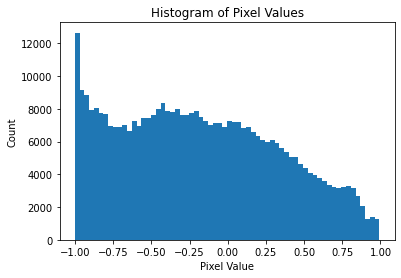

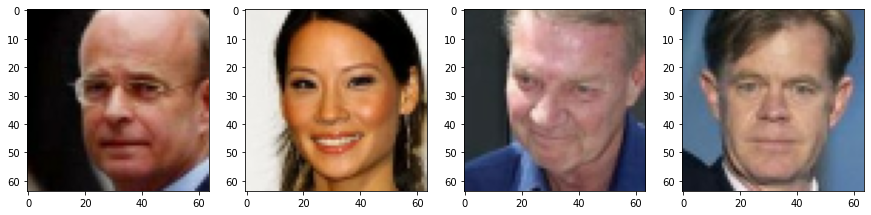

In [5]:
fig, ax = plt.subplots()
ax.hist(lfw.data_sample.reshape((-1,)), bins=64)
ax.set_xlabel('Pixel Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Pixel Values')

fig, axs = plt.subplots(1, 4, figsize=(15,5))
for i in range(4):
    axs[i].imshow(lfw.unscale_img(lfw.data_sample[i]))

In [6]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, downsample=True, scale_channels=2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=3)(x)
x = NvaeConv2D(kernel_size=1, upsample=True, scale_channels=-2)(x)
x = NvaeConv2D(kernel_size=1, abs_channels=3)(x)

test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
nvae_conv2d (NvaeConv2D)     (None, 32, 32, 32)        928       
_________________________________________________________________
nvae_conv2d_1 (NvaeConv2D)   (None, 32, 32, 32)        9280      
_________________________________________________________________
nvae_conv2d_2 (NvaeConv2D)   (None, 32, 32, 32)        9280      
_________________________________________________________________
nvae_conv2d_3 (NvaeConv2D)   (None, 16, 16, 64)        2176      
_________________________________________________________________
nvae_conv2d_4 (NvaeConv2D)   (None, 16, 16, 64)        36992     
_________________________________________________________________
nvae_conv2d_5 (NvaeConv2D)   (None, 16, 16, 64)       

In [7]:
print('Pass thru 8 images:', test_model(lfw.data_sample[:8]).shape)

Pass thru 8 images: (8, 32, 32, 3)


In [8]:
x = inputs = L.Input(shape=IMAGE_SIZE)
x = NvaeConv2D(kernel_size=3, abs_channels=32)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell()(x)
x = ResidualEncoderCell(downsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell()(x)
x = ResidualDecoderCell(upsample=True)(x)
x = NvaeConv2D(kernel_size=3, abs_channels=3)(x)
test_model = tf.keras.Model(inputs=inputs, outputs=x)
test_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
nvae_conv2d_14 (NvaeConv2D)  (None, 32, 32, 32)        928       
_________________________________________________________________
residual_encoder_cell (Resid (None, 32, 32, 32)        19108     
_________________________________________________________________
residual_encoder_cell_1 (Res (None, 32, 32, 32)        19108     
_________________________________________________________________
residual_encoder_cell_2 (Res (None, 16, 16, 64)        58628     
_________________________________________________________________
residual_encoder_cell_3 (Res (None, 16, 16, 64)        75076     
_________________________________________________________________
residual_encoder_cell_4 (Res (None, 16, 16, 64)       

In [ ]:
test_model(lfw.data_sample[:4, :16, :16, :], training=True).shape

In [11]:
# TEST THE MODEL CONSTRUCTION
full_model = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=8,
    nscales=2,
    ngroups=2,
    ncells=2,
    nlatent=8,
    num_prepost_blocks=1,
    num_prepost_cells=2)

h0 = tf.Variable(tf.random.normal((1, 16, 16, 64)))
print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=False).shape)
print('Full model output shape:', full_model(lfw.data_sample[:4, :, :, :], training=True).shape)

(PEAK) Merge mode set to merge
(PEAK) kl_loss_scalar=0.2
Sampling input shape: (None, 8, 8, 16)
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.2
Sampling input shape: (None, 8, 8, 16)
Sampling input shape: (None, 8, 8, 16)
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.2
Sampling input shape: (None, 16, 16, 16)
Sampling input shape: (None, 16, 16, 16)
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.2
Sampling input shape: (None, 16, 16, 16)
Sampling input shape: (None, 16, 16, 16)
Full model output shape: (4, 32, 32, 3)


Full model output shape: (4, 32, 32, 3)


In [12]:
full_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
pre_stem (NvaeConv2D)           (None, 32, 32, 8)    232         input_4[0][0]                    
__________________________________________________________________________________________________
pre_blk0_c0 (ResidualEncoderCel (None, 32, 32, 8)    1324        pre_stem[0][0]                   
__________________________________________________________________________________________________
pre_blk0_c1 (ResidualEncoderCel (None, 16, 16, 16)   3908        pre_blk0_c0[0][0]                
_______________________________________________________________________________________

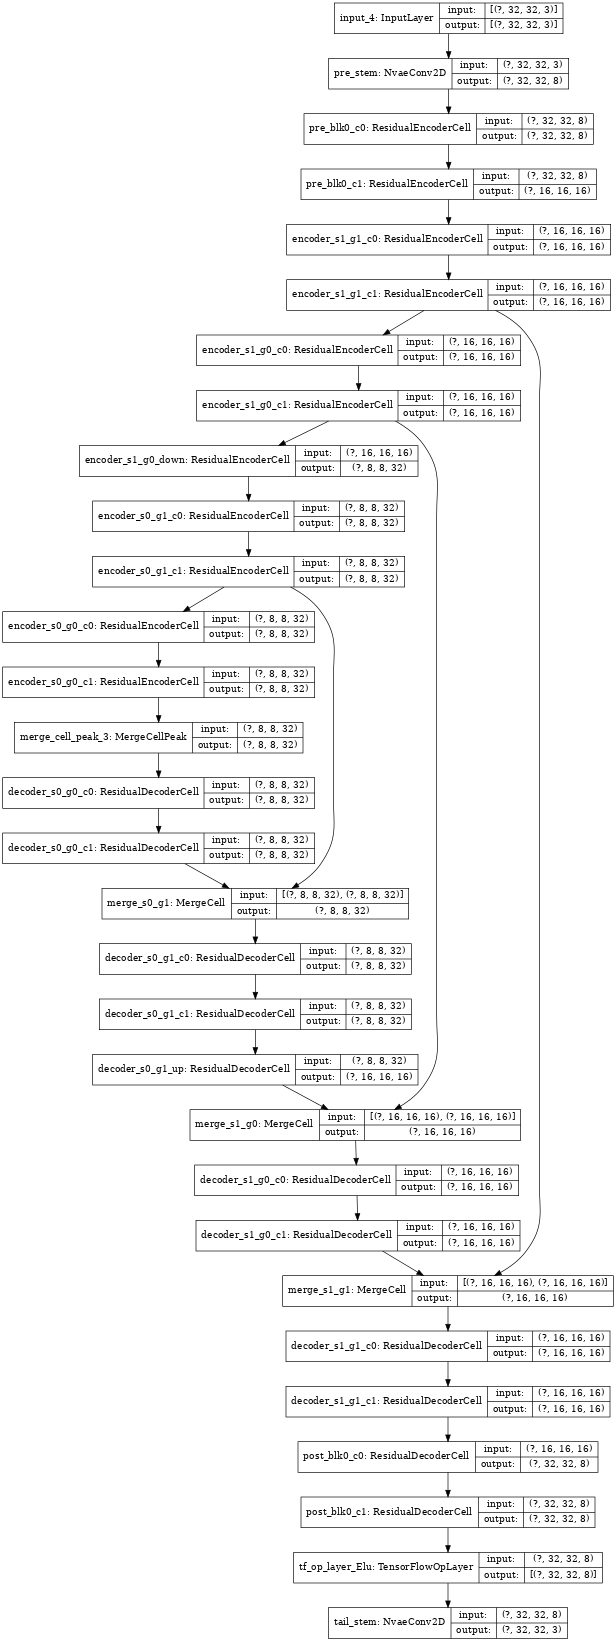

In [13]:
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48)
tf.keras.utils.plot_model(full_model, show_shapes=True, show_layer_names=True, dpi=48, to_file='small_nvae.png')

In [6]:
BATCH_SIZE=6
print('Loading the full dataset, resampled/rescaled')
#lfw.tfds_load(scale=SIZE_SCALAR, load_count=2000)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64
lfw.tfds_load(scale=SIZE_SCALAR, load_count=None)  # Images start at (160, 160, 3), rescale //2.5 to get to 64x64
train_xx, val_xx, test_xx = lfw.get_vae_data_splits(batch_size=BATCH_SIZE)

Loading the full dataset, resampled/rescaled
Train samples: 10586
Val samples:   1324
Test samples:  1323
lfw.data_sample.shape: (32, 64, 64, 3)


In [7]:
full_model = None  # release prev model
full_nvae = None  # release prev model

tf.keras.backend.clear_session()

# CELEB 64 params ... but this is 1e9 params?!
'''
INITIAL_LR = 4e-4
full_nvae = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=64,
    nscales=3,
    ngroups=20,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2)
'''
INITIAL_LR = 4e-4
full_nvae = create_nvae(
    input_shape=IMAGE_SIZE,
    base_num_channels=32,
    nscales=2,
    ngroups=12,
    ncells=2,
    nlatent=20,
    num_prepost_blocks=1,
    num_prepost_cells=2,
    kl_loss_scalar=0.02)

full_nvae.summary()

(PEAK) Merge mode set to merge
(PEAK) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_scalar=0.02
(REG) Merge mode set to merge
(REG) kl_loss_sc

In [ ]:
test_out = full_nvae(tf.zeros((BATCH_SIZE,) + IMAGE_SIZE))
opt = tf.keras.optimizers.Adamax(INITIAL_LR)
#opt = tf.keras.optimizers.Adamax()
full_nvae.compile(opt, loss='mse', metrics='mse')

cb_reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mse', factor=0.7, patience=5, verbose=1)
#cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=20, restore_best_weights=True)
cb_earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=8)
cb_chkpoint = tf.keras.callbacks.ModelCheckpoint('best_nvae', monitor='val_loss', save_best_only=True, save_weights_only=True)

hist = full_nvae.fit(
    train_xx.repeat(),
    validation_data=val_xx,
    steps_per_epoch=2000//BATCH_SIZE,
    epochs=60,
    callbacks=[cb_earlystop, cb_reducelr])
    #callbacks=[cb_chkpoint, cb_earlystop, cb_reducelr])

Epoch 1/60
333/333 [==============================] - 238s 714ms/step - loss: 0.0352 - mse: 0.0267 - val_loss: 0.0204 - val_mse: 0.0176
Epoch 2/60
333/333 [==============================] - 230s 691ms/step - loss: 0.0138 - mse: 0.0103 - val_loss: 0.0195 - val_mse: 0.0166
Epoch 3/60
333/333 [==============================] - 230s 690ms/step - loss: 0.0109 - mse: 0.0078 - val_loss: 0.0168 - val_mse: 0.0131
Epoch 4/60
333/333 [==============================] - 230s 690ms/step - loss: 0.0091 - mse: 0.0062 - val_loss: 0.0124 - val_mse: 0.0082
Epoch 5/60
333/333 [==============================] - 230s 691ms/step - loss: 0.0082 - mse: 0.0054 - val_loss: 0.0095 - val_mse: 0.0057
Epoch 6/60
333/333 [==============================] - 232s 697ms/step - loss: 0.0074 - mse: 0.0047 - val_loss: 0.0091 - val_mse: 0.0048
Epoch 7/60
333/333 [==============================] - 230s 690ms/step - loss: 0.0069 - mse: 0.0042 - val_loss: 0.0082 - val_mse: 0.0045
Epoch 8/60
333/333 [============================

In [ ]:
plt.plot(hist.history['val_mse'])
plt.plot(hist.history['val_loss'])
plt.legend(['Validation MSE', 'Validation Total Loss'])
plt.ylim(0, 0.1)
#full_nvae.load_weights('best_vae')

In [ ]:
for l in full_nvae.layers:
    try:
        l.set_merge_mode('merge')
    except Exception as e:
        pass
    
for l in full_nvae.layers:
    try:
        l.set_temperature(1.0)
    except Exception as e:
        pass
    
nvae_proc = full_nvae(lfw.data_sample)

fig, axs = plt.subplots(8, 4, figsize=(12, 20))
for a,i in enumerate(range(0, 16)):
    #print(lfw.data_sample[i].shape)
    #print(model_parts.encoder(tf.expand_dims(lfw.data_sample[i], axis=0)))
    orig = lfw.data_sample[i]
    vaed = nvae_proc[i]
    mrow = a//2
    mcol = a%2
    axs[mrow][mcol*2].imshow(lfw.unscale_img(orig))
    axs[mrow][mcol*2+1].imshow(lfw.unscale_img(vaed))

best_loss = min(hist.history['val_loss'])
    
fig.savefig(f'images/nvae_roundtrip_samples.png')

In [ ]:
for l in full_nvae.layers:
    try:
        l.set_merge_mode('sample')
    except Exception as e:
        pass
    
for l in full_nvae.layers:
    try:
        l.set_temperature(1.0)
    except Exception as e:
        pass

nvae_proc = full_nvae(tf.zeros_like(lfw.data_sample))
fig, axs = plt.subplots(8, 4, figsize=(12, 20))
for a,i in enumerate(range(0, 32)):
    #print(lfw.data_sample[i].shape)
    #print(model_parts.encoder(tf.expand_dims(lfw.data_sample[i], axis=0)))
    vaed = nvae_proc[i]
    mrow = a//4
    mcol = a%4
    axs[a//4][a%4].imshow(lfw.unscale_img(vaed))

best_loss = min(hist.history['val_loss'])
    
fig.savefig(f'images/nvae_gen_random.png')